In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/BKAI_CV/

/content/drive/MyDrive/BKAI_CV


In [3]:
!pip install torchgeometry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.4 MB/s 


In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [5]:
import pathlib
import torch

import albumentations
import numpy as np
from sklearn.model_selection import train_test_split
from torchgeometry.losses import DiceLoss
from torch.utils.data import DataLoader
from skimage.transform import resize

from UNet.customdatasets import SegmentationDataSet1, SegmentationDataSet2
from UNet.transformations import ComposeDouble, AlbuSeg2d, FunctionWrapperDouble, normalize_01, create_dense_target, convert_to_labels
from UNet.unet import UNet
from UNet.trainer import Trainer
# from UNet.loss import DiceLoss

In [6]:
root = pathlib.Path.cwd()
print(root)

/content/drive/MyDrive/BKAI_CV


In [7]:
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

In [8]:
# input and target files
inputs = get_filenames_of_path(root / 'data/reshape_new_train')
targets = get_filenames_of_path(root / 'data/reshape_new_train_gt')
print(len(inputs))

1000


In [ ]:
# # pre-transformations
# pre_transforms = ComposeDouble([
#     FunctionWrapperDouble(resize,
#                           input=True,
#                           target=False,
#                           output_shape=(128, 128, 3)),
#     FunctionWrapperDouble(resize,
#                           input=False,
#                           target=True,
#                           output_shape=(128, 128),
#                           order=0,
#                           anti_aliasing=False,
#                           preserve_range=True),
# ])

In [9]:
# training transformations and augmentations
transforms_training = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(256, 256, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(256, 256, 3),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(convert_to_labels, input = False, target = True),
    FunctionWrapperDouble(normalize_01, input = True, target = True)
])


In [11]:
# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape= (256, 256, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape= (256, 256, 3),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(convert_to_labels, input = False, target = True), #target = true
    FunctionWrapperDouble(normalize_01, input = True, target = True)
])

In [12]:
# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

In [13]:
inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

In [16]:
# dataset training
dataset_train = SegmentationDataSet2(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms_training)

# dataset validation
dataset_valid = SegmentationDataSet2(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms_validation)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=True)

In [17]:
print(len(dataloader_validation))

100


In [ ]:
print(dataloader_validation)

In [ ]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=3,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = DiceLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=2,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

In [ ]:
from UNet.lr_rate_finder import LearningRateFinder
lrf = LearningRateFinder(model, criterion, optimizer, device)
lrf.fit(dataloader_training, steps = 1000)

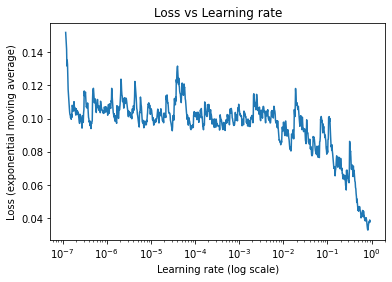

In [20]:
lrf.plot()

In [46]:
learning_rate = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [47]:
# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=10,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Output hidden; open in https://colab.research.google.com to view.

In [48]:
# !pip install napari

In [49]:
import napari

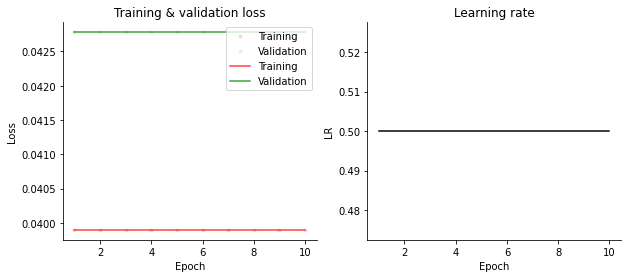

In [50]:
from UNet.visual import plot_training
fig = plot_training(
    training_losses,
    validation_losses,
    lr_rates,
    gaussian = True,
    sigma = 1,
    figsize = (10, 4)
)

In [51]:
# save the model
model_name =  'Polyp.pt'
torch.save(model.state_dict(), pathlib.Path.cwd() / model_name)
